<a href="https://colab.research.google.com/github/axeltanjung/pest_classification/blob/main/notebook/pest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Pest Classification using Convolutional Neural Network (CNN) Algorithms**

In [ ]:
!pip install opencv-python

### Import Library


In [1]:
# Import Common Library
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

# Import PyToch Library
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Check Images

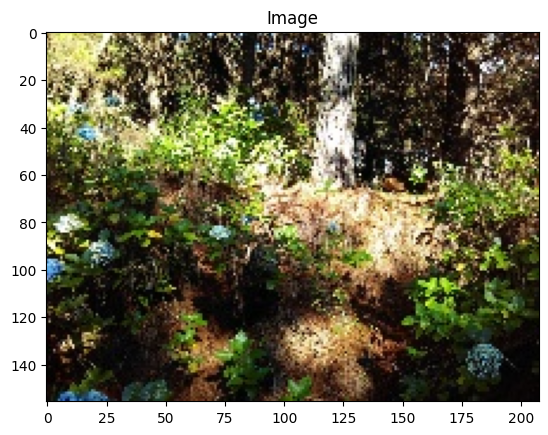

In [5]:
# Load the image using PIL
image_path = "/content/drive/MyDrive/data/test/invasive/1000.jpg"
image = Image.open(image_path)

# Define a torchvision transform to convert the PIL image to a PyTorch tensor
transform = transforms.ToTensor()
tensor_image = transform(image)

# Plot the image using matplotlib
plt.imshow(tensor_image.permute(1, 2, 0))  # Permute the dimensions for correct display
plt.title('Image')
plt.show()

### Dataset and Dataloader

In [59]:
batch_size = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("drive/MyDrive/data/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("drive/MyDrive/data/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [88]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

### Architecture and Config

### Import Library

In [62]:
import torch
import torch.nn as nn
from dataclasses import dataclass

In [63]:
_act_func = {
    "relu": nn.ReLU(),
    "lrelu": nn.LeakyReLU(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
    "elu": nn.ELU(),
    "selu": nn.SELU(),
    "softmax": nn.Softmax(1),
    "lsoftmax": nn.LogSoftmax(1)
}

### Define Conv Block and Linear Block

In [66]:
def linear_block(n_in, n_out, batch_norm=False, activation='relu', dropout=0.):
    """
    available activation {relu, lrelu, sigmoid, tanh, elu, selu, softmax, lsoftmax}
    """
    layers = [nn.Linear(n_in, n_out)]

    if batch_norm:
        layers.append(nn.BatchNorm1d(n_out))

    if activation in _act_func:
        layers.append(_act_func[activation])
    else:
        raise Exception(f"Only supports ({', '.join(_act_func.keys())})")

    if 0 < dropout <= 1:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

In [67]:
def conv_block(c_in, c_out, kernel=3, stride=1, pad=1, pool_type='max', pool_kernel=2, pool_stride=2,
               batch_norm=False, activation='relu'):
    """
    available activation {relu, lrelu, sigmoid, tanh, elu, selu, softmax, lsoftmax}
    available pool_type {max, avg}
    """
    layers = [nn.Conv2d(c_in, c_out, kernel_size=kernel, stride=stride, padding=pad)]

    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))

    if activation in _act_func:
        layers.append(_act_func[activation])
    else:
        raise Exception(f"Only supports ({', '.join(_act_func.keys())})")

    if pool_type == "max":
        layers.append(nn.MaxPool2d(pool_kernel, pool_stride))
    elif pool_type == "avg":
        layers.append(nn.AvgPool2d(pool_kernel, pool_stride))
    elif pool_type is None:
        pass
    else:
        raise Exception("Only supports (max, avg)")
    return nn.Sequential(*layers)

In [68]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # 1st hidden layer
            conv_block(3, 8),
            # 2st hidden layer
            conv_block(8, 16),
            # 3st hidden layer
            conv_block(16, 32),
            # 4st hidden layer
            conv_block(32, 64),
            # Flatten
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            # Fully Connected
            linear_block(64*4*4, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )

    def forward(self, x):
        return self.fc(self.conv(x))

In [69]:
# Initialize models
model_CNN = CNN()

# Print number of parameters
print('Total Parameters :', sum(p.nelement() for p in model_cnn.parameters()))

Total Parameters : 287442


## Training Preparation

In [71]:
class Callback:
    """
    Callback for common PyTorch Workflow:
    - Neat Checkpoint and Logs
    - Early stopping
    - Runtime Plotting
    - Runtime Log and Reporting


    == Arguments ==
    model: torch.nn.Module
        A deep learning architecture using PyTorch nn.Module

    config: Config
        a config object containing the architecture parameters' that you would want to save

    save_every: int
        number of epoch to save a checkpoint

    early_stop_patience: int
        number of patience before executing early stopping

    plot_every: int
        number of epoch to perform runtime plotting

    outdir: string
        path of output directory to save the weights, configs, and logs


    == Example Usage ==
    # Logging and Reporting
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break
    """

    def __init__(self, model, config=None, save_every=50, early_stop_patience=5,
                 plot_every=20, outdir="model"):
        self.save_every = save_every
        self.early_stop_patience = early_stop_patience
        self.plot_every = plot_every
        self.outdir = outdir

        self.ckpt = Checkpoint(model, config)
        os.makedirs(self.outdir, exist_ok=True)

    def save_checkpoint(self):
        if self.ckpt.epoch % self.save_every == 0:
            self._save("checkpoint")

    def early_stopping(self, model, monitor='test_score', load_best_when_stop=True):
        stop = False
        if monitor == "train_cost":
            reference = self.ckpt.train_cost[-1]
            improve = reference < self.ckpt.best_cost
        elif monitor == "test_cost":
            reference = self.ckpt.test_cost[-1]
            improve = reference < self.ckpt.best_cost
        elif monitor == "train_score":
            reference = self.ckpt.train_score[-1]
            improve = reference > self.ckpt.best_score
        elif monitor == "test_score":
            reference = self.ckpt.test_score[-1]
            improve = reference > self.ckpt.best_score
        else:
            raise Exception('Only supports monitor={"train_cost", "test_cost", "train_score", "test_score"}')

        if improve:
            if monitor.endswith("_cost"):
                self.ckpt.best_cost = reference
            elif monitor.endswith("_score"):
                self.ckpt.best_score = reference
            self.ckpt.weights = model.state_dict().copy()
            self.reset_early_stop()
            self._save("best")
        else:
            self.ckpt.early_stop += 1
            best = self.ckpt.best_cost if monitor.endswith("_cost") else self.ckpt.best_score
            print(f"\x1b[31m==> EarlyStop patience = {self.ckpt.early_stop:2} | Best {monitor}: {best:.4f}\x1b[0m")

            if self.ckpt.early_stop >= self.early_stop_patience:
                print(f'\x1b[31m==> Execute Early Stopping at epoch: {self.ckpt.epoch} | Best {monitor}: {best:.4f}\x1b[0m')
                print(f'\x1b[31m==> Best model is saved at {self.outdir}\x1b[0m')
                stop = True

                if load_best_when_stop:
                    weights = torch.load(f'{self.outdir}/weights_best.pth', map_location="cpu")
                    model.load_state_dict(weights)

        self.next_epoch()
        return stop

    def cost_runtime_plotting(self, scale="semilogy", figsize=(8, 5)):
        if self.ckpt.epoch % self.plot_every == 0:
            self._plot(scale, figsize, mode="Cost")

    def score_runtime_plotting(self, scale="linear", figsize=(8, 5)):
        if self.ckpt.epoch % self.plot_every == 0:
            self._plot(scale, figsize, mode="Score")

    def plot_cost(self, scale="semilogy", figsize=(8, 5)):
        self._plot(scale, figsize, mode="Cost")

    def plot_score(self, scale="linear", figsize=(8, 5)):
        self._plot(scale, figsize, mode="Score")

    def log(self, train_cost=None, test_cost=None, train_score=None, test_score=None):
        report = f'\nEpoch {self.ckpt.epoch:5}\n'
        if train_cost is not None:
            train_cost = train_cost.item() if type(train_cost) == torch.Tensor else train_cost
            self.ckpt.train_cost.append(train_cost)
            report += f'Train_cost  = {train_cost:.4f} | '
        if test_cost is not None:
            test_cost = test_cost.item() if type(test_cost) == torch.Tensor else test_cost
            self.ckpt.test_cost.append(test_cost)
            report += f'Test_cost  = {test_cost:.4f} | '
        if train_score is not None:
            train_score = train_score.item() if type(train_score) == torch.Tensor else train_score
            self.ckpt.train_score.append(train_score)
            report += f'Train_score = {train_score:.4f} | '
        if test_score is not None:
            test_score = test_score.item() if type(test_score) == torch.Tensor else test_score
            self.ckpt.test_score.append(test_score)
            report += f'Test_score = {test_score:.4f} |'

        self.ckpt.plot_tick.append(self.ckpt.epoch)
        print(report)

    def next_epoch(self):
        self.ckpt.epoch += 1

    def reset_early_stop(self):
        self.ckpt.early_stop = 0

    def _plot(self, scale, figsize, mode):
        plot_func = self._plot_func(scale)

        plt.figure(figsize=figsize)
        plt.ylabel(mode)
        plt.xlabel("Epoch")
        if mode == "Cost":
            plot_func(self.ckpt.plot_tick, self.ckpt.train_cost, 'r-', label="Train")
            if self.ckpt.test_cost != []:
                plot_func(self.ckpt.plot_tick, self.ckpt.test_cost, 'b-', label="Test")
        elif mode == "Score":
            plot_func(self.ckpt.plot_tick, self.ckpt.train_score, 'r-', label="Train")
            if self.ckpt.test_score != []:
                plot_func(self.ckpt.plot_tick, self.ckpt.test_score, 'b-', label="Test")
        plt.legend()
        plt.show();

    def _save(self, mode):
        # Save weights
        weights = self.ckpt.weights
        if mode == "checkpoint":
            torch.save(weights, f'{self.outdir}/weights_{self.ckpt.epoch}.pth')
        elif mode == "best":
            torch.save(weights, f'{self.outdir}/weights_best.pth')

        # Save config if exist
        if self.ckpt.config is not None:
            configs = self.ckpt.config
            torch.save(configs, f'{self.outdir}/configs.pth')

        # Save logs
        logs = self._parse_logs()
        torch.save(logs, f'{self.outdir}/logs.pth')

    def _parse_logs(self):
        logs = {
            "plot_tick": self.ckpt.plot_tick
        }
        if self.ckpt.best_cost < np.inf:
            logs["best_cost"] = self.ckpt.best_cost
        if self.ckpt.best_score > 0:
            logs["best_score"] = self.ckpt.best_score

        if self.ckpt.train_cost != []:
            logs["train_cost"] = self.ckpt.train_cost
        if self.ckpt.train_score != []:
            logs["train_score"] = self.ckpt.train_score

        if self.ckpt.test_cost != []:
            logs["test_cost"] = self.ckpt.test_cost
        if self.ckpt.test_score != []:
            logs["test_score"] = self.ckpt.test_score
        return logs

    @staticmethod
    def _plot_func(scale):
        if scale == "linear":
            plot_func = plt.plot
        elif scale == "semilogx":
            plot_func = plt.semilogx
        elif scale == "semilogy":
            plot_func = plt.semilogy
        elif scale == "loglog":
            plot_func = plt.loglog
        else:
            raise Exception('Only supports scale={"linear", "semilogx", "semilogy", "loglog"}')
        return plot_func


class Checkpoint:
    def __init__(self, model, config):
        self.train_cost = []
        self.test_cost = []
        self.train_score = []
        self.test_score = []
        self.plot_tick = []
        self.best_cost = np.inf
        self.best_score = 0
        self.weights = model.state_dict()
        self.epoch = 1
        self.early_stop = 0
        self.config = config


In [72]:
class Config:
    def __init__(self):
        pass

    def __repr__(self):
        params = [f"{k}={v}" for k, v in sorted(self.__dict__.items())]
        return f"Config({', '.join(params)})"


def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config

In [73]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir = "model")

## Training

In [76]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  try:
    if mode == "train":
      model.train()
    elif mode == "test":
      model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
      feature, target = feature.to(device), target.to(device)
      output = model(feature)
      loss = criterion(output, target)

      if mode == "train":
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      cost += loss.item() + feature.shape[0]
      correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
  except:
    pass
  return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 1.0043 | Test_cost  = 1.0040 | Train_score = 0.7340 | Test_score = 0.8525 |
==> EarlyStop patience =  7 | Best test_score: 0.8525
==> Execute Early Stopping at epoch: 15 | Best test_score: 0.8525
==> Best model is saved at model


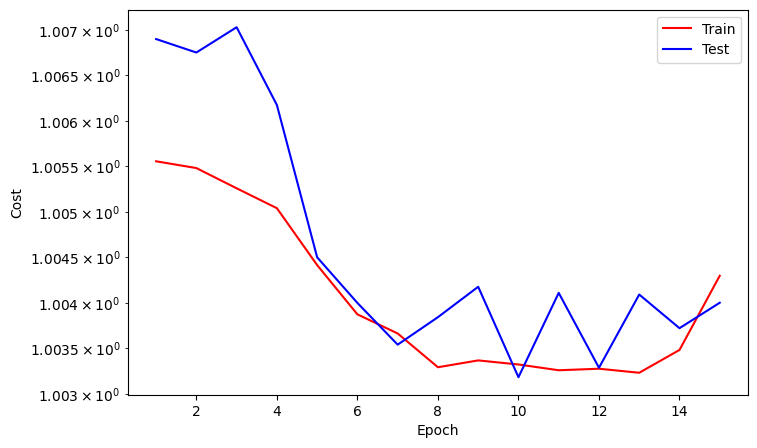

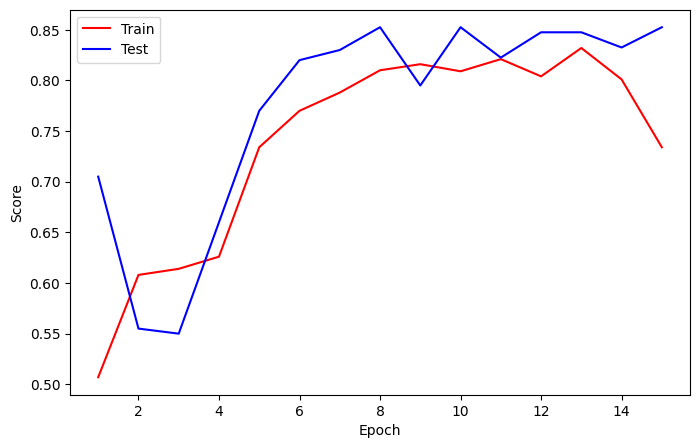

In [78]:
while True:
  train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early stopping
    if callback.early_stopping(model, monitor="test_score"):
      callback.plot_cost()
      callback.plot_score()
      break

## Predict

In [79]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [81]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')

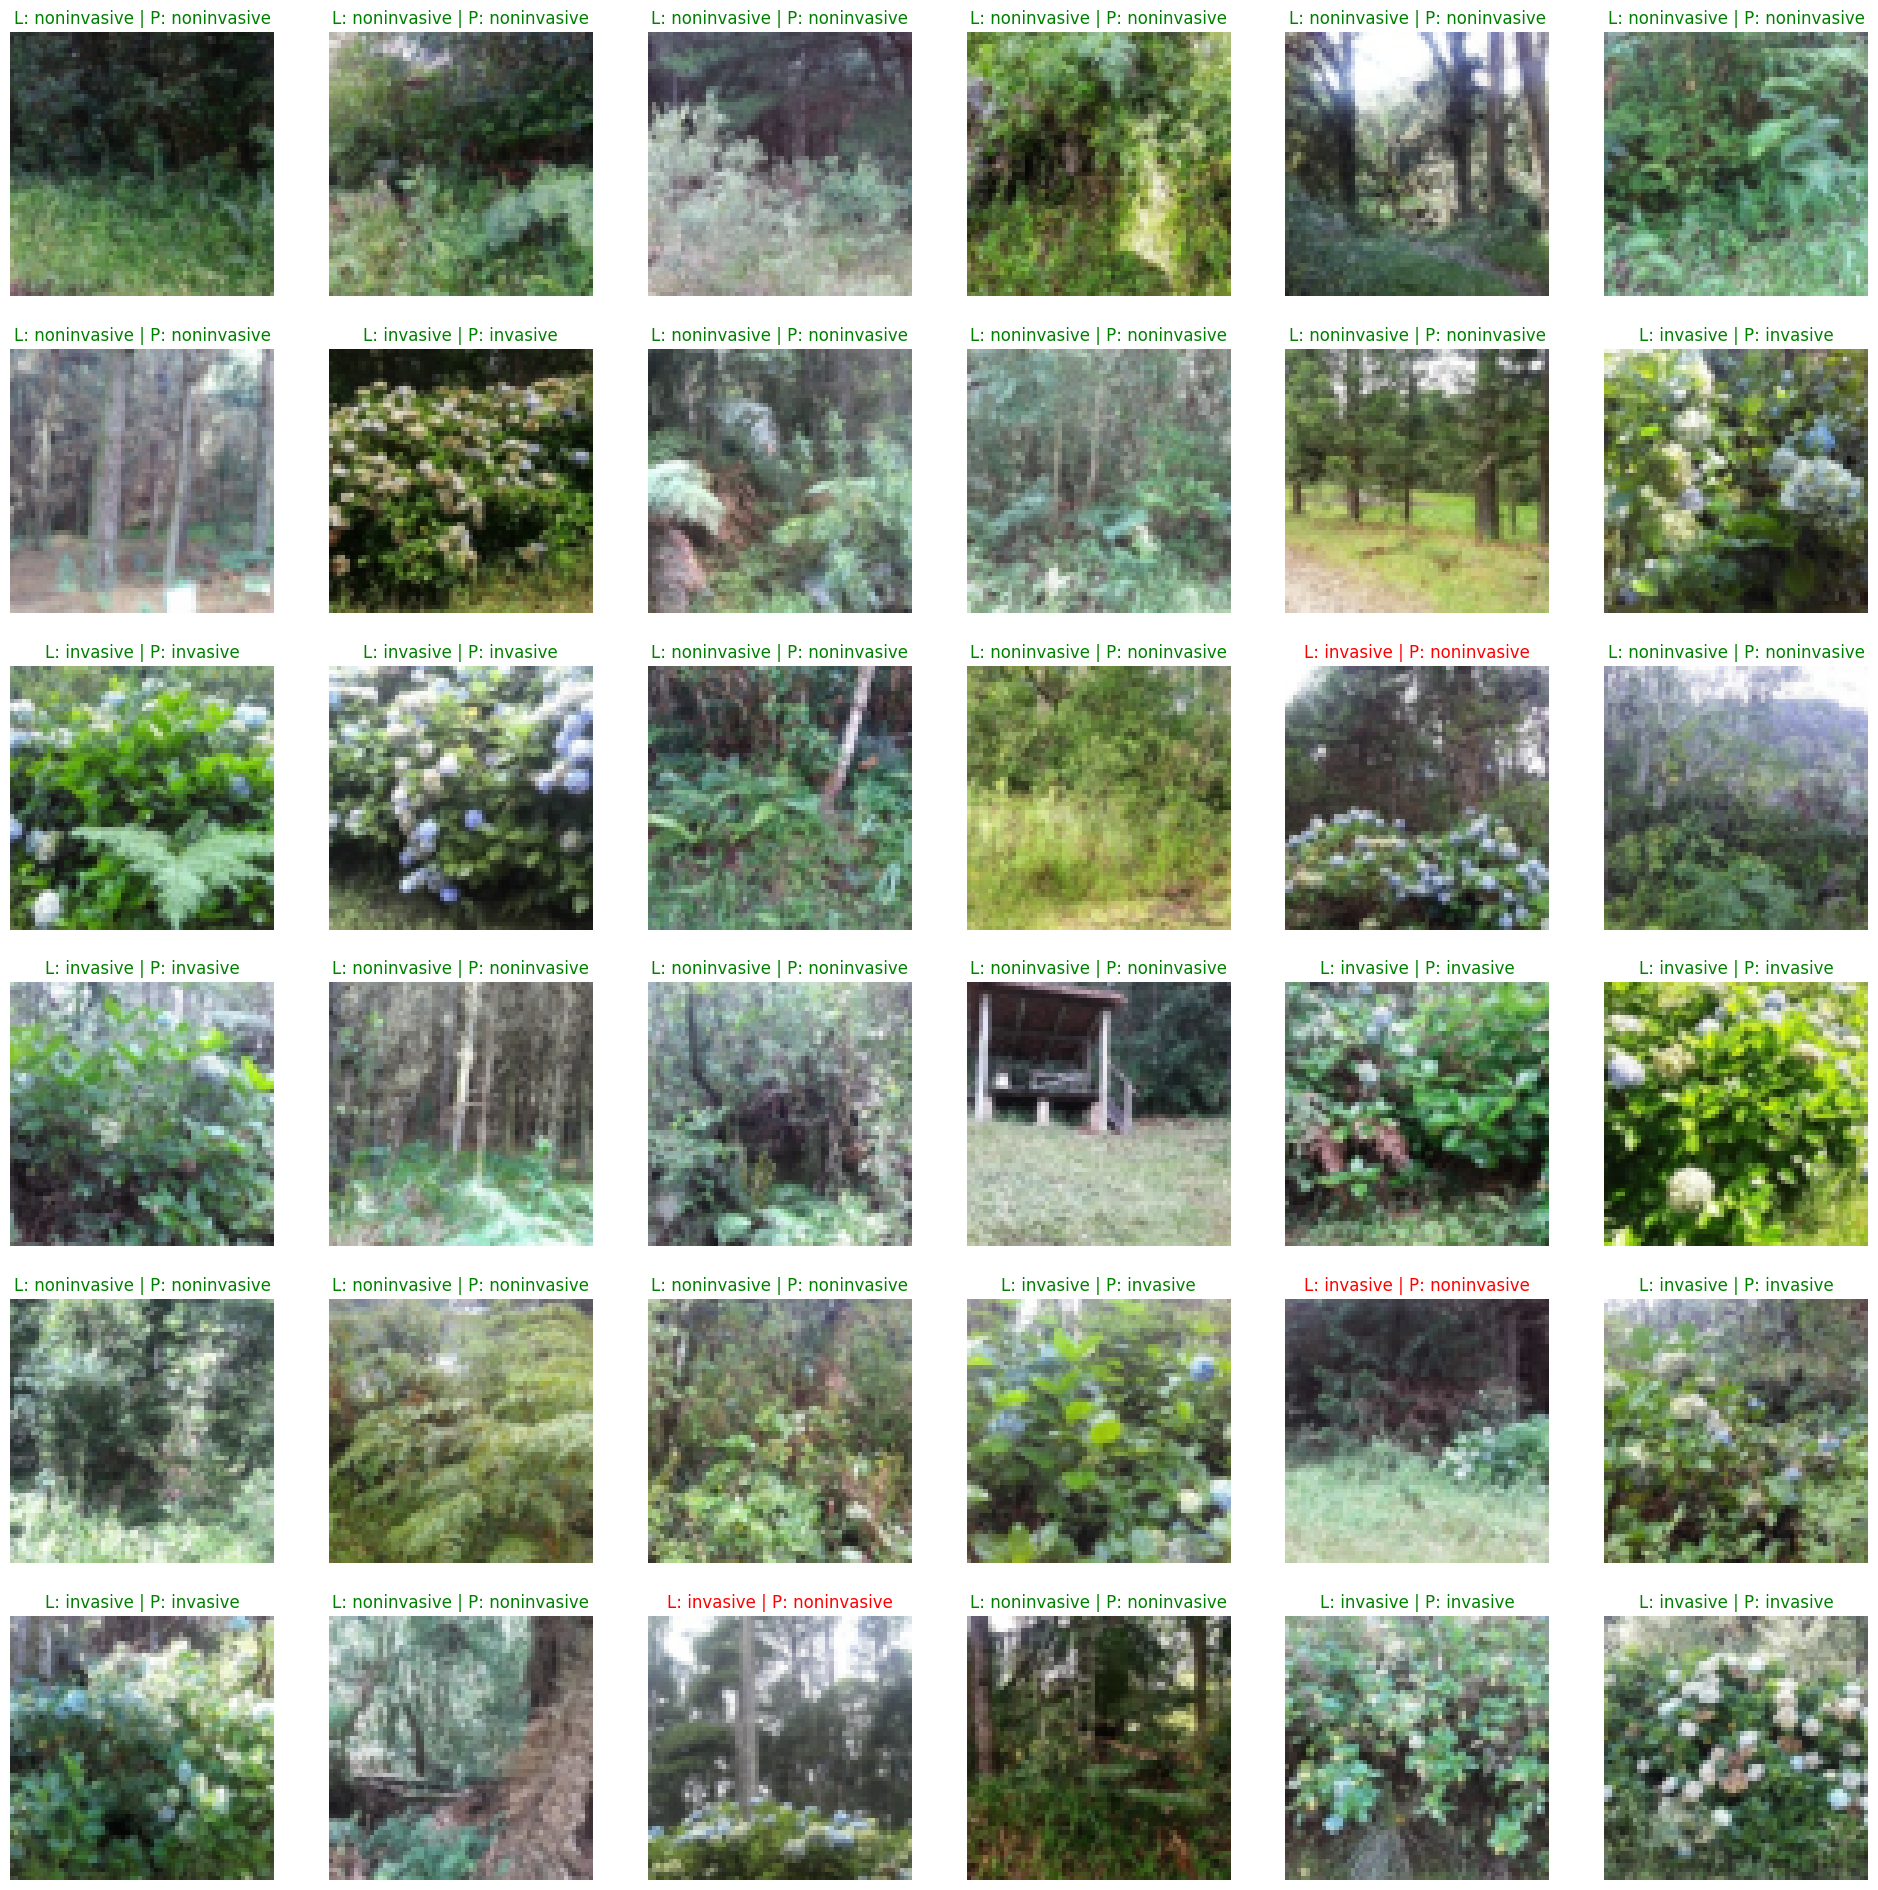

In [89]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(image.permute(1, 2, 0).cpu())
  font = {"color":'r'} if label != pred else {"color":'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
  ax.axis('off');